Tensorflow Chessbot - Predicting chess pieces from images by training a single-layer classifier
---
**[Link to Github source code](https://github.com/Elucidation/tensorflow_chessbot)**

Other IPython Notebooks for Tensorflow Chessbot:

1. [Computer Vision to turn a Chessboard image into chess tiles](tensorflow_compvision.html) - [Blog post #1](http://www.samansari.info/2016/02/learning-tensorflow-1-using-computer.html)
1. [Programmatically generating training datasets](tensorflow_generate_training_data.html)
1. [Predicting chess pieces from images by training a single-layer classifier](index.html) (*This notebook*) - [Blog post #2](http://www.samansari.info/2016/02/learning-tensorflow-2-training.html)
1. [Chessboard Convolutional Neural Network classifier](tensorflow_learn_cnn.html)
---

In this notebook we'll train a tensorflow neural network to tell what piece is on a chess square.
In the previous notebook we wrote scripts that parsed input images which contained a chessboard into 32x32 grayscale chess squares.

In [1]:
# Init and helper functions
import tensorflow as tf
import numpy as np
import PIL
import urllib, cStringIO
import glob
from IPython.core.display import Markdown
from IPython.display import Image, display

import helper_functions as hf
import tensorflow_chessbot

np.set_printoptions(precision=2, suppress=True)

Let's load the tiles in for the training and test dataset, and then split them in a 90/10 ratio

In [24]:
# All tiles with pieces in random organizations
all_paths = np.array(glob.glob("tiles/train_tiles_C/*/*.png")) # TODO : (set labels correctly)

# Shuffle order of paths so when we split the train/test sets the order of files doesn't affect it
np.random.shuffle(all_paths)

ratio = 0.9 # training / testing ratio
divider = int(len(all_paths) * ratio)
train_paths = all_paths[:divider]
test_paths = all_paths[divider:]

# Training dataset
# Generated by programmatic screenshots of lichess.org/editor/<FEN-string>
print "Loading %d Training tiles" % train_paths.size
train_images, train_labels = hf.loadFENtiles(train_paths) # Load from generated set

# Test dataset, taken from screenshots of the starting position
print "Loading %d Training tiles" % test_paths.size
test_images, test_labels = hf.loadFENtiles(test_paths) # Load from generated set

train_dataset = hf.DataSet(train_images, train_labels, dtype=tf.float32)
test_dataset = hf.DataSet(test_images, test_labels, dtype=tf.float32)

Loading 8294 Training tiles
. . . . . . . . . Done
Loading 922 Training tiles
. Done


Cool, lets look at a few images in the training set

5768: Piece(n)


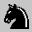

2722: Piece(b)


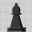

5919: Piece(k)


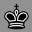

4806: Piece(k)


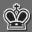

6362: Piece(p)


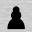

In [44]:
# Visualize a couple tiles
for i in np.random.choice(train_dataset.num_examples, 5, replace=False):
#for i in range(train_dataset.num_examples):
    #if hf.label2Name(train_dataset.labels[i]) == 'P':
        #print "%d: Piece(%s) : Label vector: %s" % (i, hf.label2Name(train_dataset.labels[i]), train_dataset.labels[i])
        print "%d: Piece(%s)" % (i, hf.label2Name(train_dataset.labels[i]))
        hf.display_array(np.reshape(train_dataset.images[i,:],[32,32]))

Looks good. Now that we've loaded the data, let's build up a simple softmax regression classifier based off of [this beginner tutorial](https://www.tensorflow.org/versions/v0.6.0/tutorials/mnist/beginners/index.html) on tensorflow.

In [4]:
x = tf.placeholder(tf.float32, [None, 32*32])
W = tf.Variable(tf.zeros([32*32, 13]))
b = tf.Variable(tf.zeros([13]))

y = tf.nn.softmax(tf.matmul(x, W) + b)
y_ = tf.placeholder(tf.float32, [None, 13])

cross_entropy = -tf.reduce_sum(y_*tf.log(y))

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(cross_entropy)
# train_step = tf.train.AdamOptimizer(0.01).minimize(cross_entropy)

init = tf.initialize_all_variables()


sess = tf.Session()
sess.run(init)

N = 6000
print "Training for %d steps..." % N
for i in range(N):
    batch_xs, batch_ys = train_dataset.next_batch(100)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
    if ((i+1) % 500) == 0:
        print "\t%d/%d" % (i+1, N)
print "Finished training."

Training for 6000 steps...
	500/6000
	1000/6000
	1500/6000
	2000/6000
	2500/6000
	3000/6000
	3500/6000
	4000/6000
	4500/6000
	5000/6000
	5500/6000
	6000/6000
Finished training.


In [5]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
print "Accuracy: %g\n" % sess.run(accuracy, feed_dict={x: test_dataset.images, y_: test_dataset.labels})

Accuracy: 0.996142



Looks like it memorized everything from the datasets we collected, let's look at the weights to get an idea of what it sees for each piece.

# Weights

Visualization of Weights as negative(Red) to positive(Blue)
Piece:  


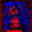

Piece: K


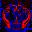

Piece: Q


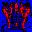

Piece: R


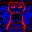

Piece: B


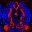

Piece: N


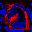

Piece: P


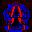

Piece: k


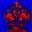

Piece: q


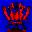

Piece: r


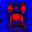

Piece: b


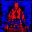

Piece: n


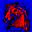

Piece: p


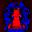

In [6]:
print "Visualization of Weights as negative(Red) to positive(Blue)"
for i in range(13):
    print "Piece: %s" % hf.labelIndex2Name(i)
    piece_weight = np.reshape(sess.run(W)[:,i], [32,32])
    hf.display_weight(piece_weight,rng=[-0.2,0.2])

Cool, you can see the shapes show up within the weights. Let's have a look at the failure cases to get a sense of what went wrong.

32 mistakes:
---
	#3366 | Actual: 'P', Guessed: ' '
Actual: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 Guess: [ 0.44  0.04  0.11  0.04  0.14  0.02  0.21  0.    0.    0.    0.    0.    0.  ]


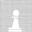

---
	#2634 | Actual: 'R', Guessed: ' '
Actual: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 Guess: [ 0.28  0.2   0.15  0.15  0.13  0.07  0.02  0.    0.    0.    0.    0.    0.  ]


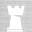

---
	#1520 | Actual: 'B', Guessed: ' '
Actual: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 Guess: [ 0.31  0.05  0.16  0.08  0.29  0.03  0.07  0.    0.    0.    0.    0.    0.  ]


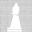

---
	#3202 | Actual: 'R', Guessed: 'r'
Actual: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 Guess: [ 0.    0.    0.    0.3   0.04  0.    0.07  0.04  0.01  0.5   0.01  0.03
  0.  ]


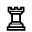

---
	#535 | Actual: 'R', Guessed: ' '
Actual: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 Guess: [ 0.27  0.18  0.16  0.15  0.13  0.07  0.03  0.    0.    0.    0.    0.    0.  ]


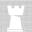

In [7]:
mistakes = tf.where(~correct_prediction)
mistake_indices = sess.run(mistakes, feed_dict={x: test_dataset.images,
                                                y_: test_dataset.labels}).flatten()

guess_prob, guessed = sess.run([y, tf.argmax(y,1)], feed_dict={x: test_dataset.images})

print "%d mistakes:" % mistake_indices.size

for idx in np.random.choice(mistake_indices, 5, replace=False):
    a,b = test_dataset.labels[idx], guessed[idx]
    print "---"
    print "\t#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    print "Actual:",a
    print " Guess:",guess_prob[idx,:]
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))

It looks like it's been learning that pieces have black borders, and since this pieceSet didn't, and it was a small part of the training set, it just fails and thinks we're looking at blank squares, *more training data!* 
From the label probabilities, it did a reasonable job of thinking the pieces were white, and their second best guesses tended to be close to the right answer, the blank spaces just won out.

Also, lets look at several random selections, including successes.

#4662 | Actual: 'N', Guessed: 'N'


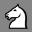

#4761 | Actual: 'N', Guessed: 'N'


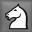

#4079 | Actual: 'n', Guessed: 'n'


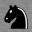

#7440 | Actual: 'p', Guessed: 'p'


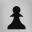

#8233 | Actual: 'P', Guessed: 'P'


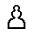

In [8]:
for idx in np.random.choice(test_dataset.num_examples,5,replace=False):
    a,b = test_dataset.labels[idx], guessed[idx]
    print "#%d | Actual: '%s', Guessed: '%s'" % (idx, hf.label2Name(a),hf.labelIndex2Name(b))
    hf.display_array(np.reshape(test_dataset.images[idx,:],[32,32]))

# Manual validation via screenshots on reddit
We'll eventually build a training/test/validation dataset of different proportions in one go, but for now, lets build a wrapper that given an image, returns a predicted FEN

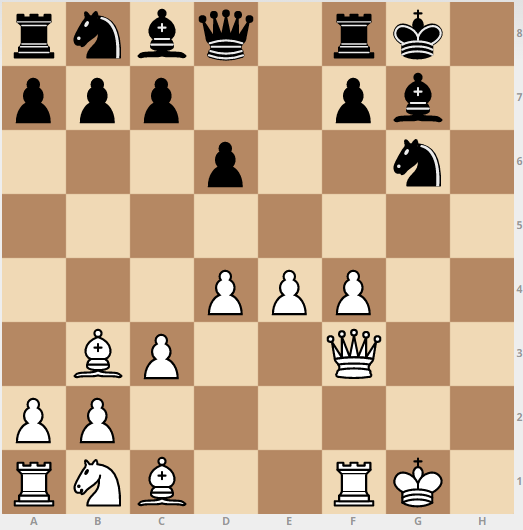

Let's see the 5th tile, corresponding to F1


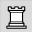

In [9]:
validate_img_path = 'chessboards/reddit/aL64q8w.png'
img_arr = tensorflow_chessbot.loadImage(validate_img_path)
tiles = tensorflow_chessbot.getTiles(img_arr)

# See the screenshot
display(Image(validate_img_path))

# see one of the tiles
print "Let's see the 5th tile, corresponding to F1"
hf.display_array(tiles[:,:,5])


First 5 tiles
#0 | Actual: '?', Guessed: 'R'


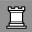

#1 | Actual: '?', Guessed: 'N'


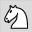

#2 | Actual: '?', Guessed: 'B'


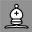

#3 | Actual: '?', Guessed: ' '


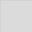

#4 | Actual: '?', Guessed: ' '


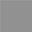

In [10]:
validation_set = np.swapaxes(np.reshape(tiles, [32*32, 64]),0,1)

guess_prob, guessed = sess.run([y, tf.argmax(y,1)], feed_dict={x: validation_set})

print "First 5 tiles"
for idx in range(5):
    guess = guessed[idx]
    print "#%d | Actual: '?', Guessed: '%s'" % (idx, hf.labelIndex2Name(guess))
    hf.display_array(np.reshape(validation_set[idx,:],[32,32]))

Oh my, that looks correct, let's generate a FEN string from the `guessed` results, and view that side by side with the screenshot!

FEN: rnbq1rk1/ppp11pb1/111p11n1/11111111/111PPP11/1BP11Q11/PP111111/RNB11RK1


Prediction: [Lichess analysis](https://lichess.org/analysis/rnbq1rk1/ppp11pb1/111p11n1/11111111/111PPP11/1BP11Q11/PP111111/RNB11RK1)

Actual


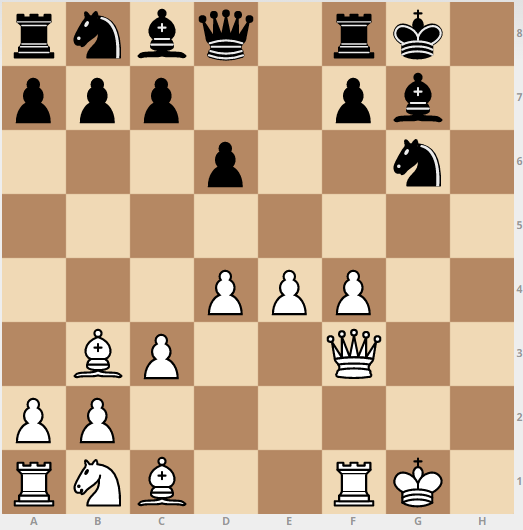

In [11]:
# guessed is tiles A1-H8 rank-order, so to make a FEN we just need to flip the files from 1-8 to 8-1
pieceNames = map(lambda k: '1' if k == 0 else hf.labelIndex2Name(k), guessed) # exchange ' ' for '1' for FEN
fen = '/'.join([''.join(pieceNames[i*8:(i+1)*8]) for i in reversed(range(8))])

print "FEN:",fen

# See our prediction as a chessboard
display(Markdown("Prediction: [Lichess analysis](https://lichess.org/analysis/%s)" % fen))
display(Image(url='http://www.fen-to-image.com/image/%s' % fen))

# See the original screenshot we took from reddit
print "Actual"
display(Image(validate_img_path))

A perfect match! Awesome, at this point even though we have enough to make predictions from several lichess boards (not all of them yet) and return a result. We can build our reddit chatbot now. 

# Predict from image url

Let's wrap up predictions into a single function call from a URL, and test it on a few reddit posts.

In [12]:
def getPrediction(img):
    """Run trained neural network on tiles generated from image"""
    
    # Convert to grayscale numpy array
    img_arr = np.asarray(img.convert("L"), dtype=np.float32)
    
    # Use computer vision to get the tiles
    tiles = tensorflow_chessbot.getTiles(img_arr)
    if tiles is []:
        print "Couldn't parse chessboard"
        return ""
    
    # Reshape into Nx1024 rows of input data, format used by neural network
    validation_set = np.swapaxes(np.reshape(tiles, [32*32, 64]),0,1)

    # Run neural network on data
    guess_prob, guessed = sess.run([y, tf.argmax(y,1)], feed_dict={x: validation_set})
    
    # Convert guess into FEN string
    # guessed is tiles A1-H8 rank-order, so to make a FEN we just need to flip the files from 1-8 to 8-1
    pieceNames = map(lambda k: '1' if k == 0 else hf.labelIndex2Name(k), guessed) # exchange ' ' for '1' for FEN
    fen = '/'.join([''.join(pieceNames[i*8:(i+1)*8]) for i in reversed(range(8))])
    return fen

def makePrediction(image_url):
    """Given image url to a chessboard image, return a visualization of FEN and link to a lichess analysis"""
    # Load image from url and display
    img = PIL.Image.open(cStringIO.StringIO(urllib.urlopen(image_url).read()))
    
    print "Image on which to make prediction: %s" % image_url
    hf.display_image(img.resize([200,200], PIL.Image.ADAPTIVE))
    
    # Make prediction
    fen = getPrediction(img)
    display(Markdown("Prediction: [Lichess analysis](https://lichess.org/analysis/%s)" % fen))
    display(Image(url='http://www.fen-to-image.com/image/%s' % fen))
    print "FEN: %s" % fen    


## Make Predictions

All the boilerplate is done, the model is trained, it's time. I chose the first post I saw on reddit.com/chess with a chessboard (something our CV algorithm can do also): https://www.reddit.com/r/chess/comments/45inab/moderate_black_to_play_and_win/ with an image url of http://i.imgur.com/x6lLQQK.png

And awaayyy we gooo...

Image on which to make prediction: http://i.imgur.com/x6lLQQK.png


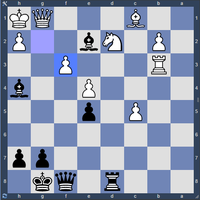

Prediction: [Lichess analysis](https://lichess.org/analysis/KQ111B11/P11bN1P1/11P111R1/b11P1111/111p1P11/11111111/pp111111/1kq1r111)

FEN: KQ111B11/P11bN1P1/11P111R1/b11P1111/111p1P11/11111111/pp111111/1kq1r111


In [13]:
makePrediction('http://i.imgur.com/x6lLQQK.png')

Fantastic, a perfect match! It was able to handle the highlighting on the pawn movement from G2 to F3 also. 

Now just for fun, let's try an image that is from a chessboard we've never seen before! Here's another on reddit: https://www.reddit.com/r/chess/comments/45c8ty/is_this_position_starting_move_36_a_win_for_white/

Image on which to make prediction: http://i.imgur.com/r2r43xA.png


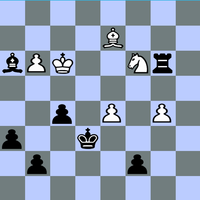

Prediction: [Lichess analysis](https://lichess.org/analysis/11111111/1111B111/bBK11Nr1/11111111/11b1B1B1/b11k1111/1b111b11/11111111)

FEN: 11111111/1111B111/bBK11Nr1/11111111/11b1B1B1/b11k1111/1b111b11/11111111


In [14]:
makePrediction('http://i.imgur.com/r2r43xA.png')

Hah, it thought the black pawns (on A3, B2, C4, and F2) were black bishops. Same for the white pawns. This would be a pretty bad situation for white. But amazingly it predicted all the other pieces and empty squares correctly! This is pretty great, let's look at a few more screenshots taken lichess. Here's https://www.reddit.com/r/chess/comments/44q2n6/tactic_from_a_game_i_just_played_white_to_move/

Image on which to make prediction: http://i.imgur.com/gSFbM1d.png


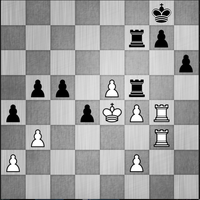

Prediction: [Lichess analysis](https://lichess.org/analysis/111111k1/11111rp1/1111111p/1pp1Pr11/p11pKPR1/1P1111R1/P1111P11/11111111)

FEN: 111111k1/11111rp1/1111111p/1pp1Pr11/p11pKPR1/1P1111R1/P1111P11/11111111


In [15]:
makePrediction('http://i.imgur.com/gSFbM1d.png')

Perfect match, as expected, when the validation images are based off of what the model trains, it'll do great, but if we use images from chess boards we haven't trained on, we'll see lots of mistakes. Mistakes are fun, lets see some.

## Trying with non-lichess images

Image on which to make prediction: http://imgur.com/oXpMSQI.png


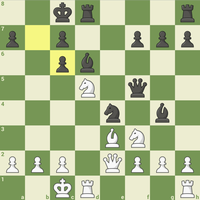

Prediction: [Lichess analysis](https://lichess.org/analysis/11kr111r/p1p11ppp/11pb1111/111N1q11/1111n1b1/1111BN11/PPP1QPPP/11KR111R)

FEN: 11kr111r/p1p11ppp/11pb1111/111N1q11/1111n1b1/1111BN11/PPP1QPPP/11KR111R


In [16]:
makePrediction('http://imgur.com/oXpMSQI.png')

Ouch, it missed most of them there, the training data didn't contain images from this site, which looks somewhat like chess.com, need more DATA!

Image on which to make prediction: http://imgur.com/qk5xa6q.png


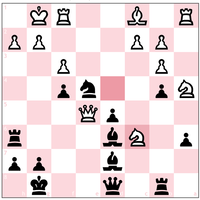

Prediction: [Lichess analysis](https://lichess.org/analysis/1Qr11B1r/pp111pp1/11p111p1/11pn11pB/111qp111/r111bB1p/pp11b111/1k11q1r1)

FEN: 1Qr11B1r/pp111pp1/11p111p1/11pn11pB/111qp111/r111bB1p/pp11b111/1k11q1r1


In [17]:
makePrediction('http://imgur.com/qk5xa6q.png')

Image on which to make prediction: http://imgur.com/u4zF5Hj.png


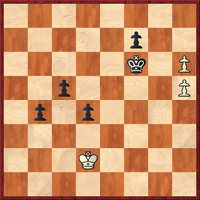

Prediction: [Lichess analysis](https://lichess.org/analysis/11111111/11111p11/11111R1P/11p11111/1p1p1111/11111111/111K1111/11111111)

FEN: 11111111/11111p11/11111R1P/11p11111/1p1p1111/11111111/111K1111/11111111


In [18]:
makePrediction('http://imgur.com/u4zF5Hj.png')

Image on which to make prediction: http://imgur.com/CW675pw.png


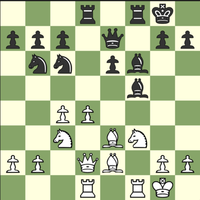

Prediction: [Lichess analysis](https://lichess.org/analysis/111r1rk1/ppp1q1pp/1nn1pb11/11111b11/11bP1111/11N1BN11/pP1QB1bP/111R1RK1)

FEN: 111r1rk1/ppp1q1pp/1nn1pb11/11111b11/11bP1111/11N1BN11/pP1QB1bP/111R1RK1


In [19]:
makePrediction('http://imgur.com/CW675pw.png')

Image on which to make prediction: https://i.ytimg.com/vi/pG1Uhw3pO8o/hqdefault.jpg


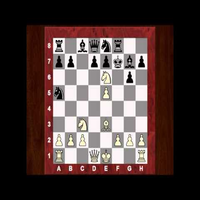

Prediction: [Lichess analysis](https://lichess.org/analysis/r1bqnr11/pp1ppkbp/1111N1p1/n111P111/11111111/11N1B111/PPP11PPP/R11QK11R)

FEN: r1bqnr11/pp1ppkbp/1111N1p1/n111P111/11111111/11N1B111/PPP11PPP/R11QK11R


In [20]:
makePrediction('https://i.ytimg.com/vi/pG1Uhw3pO8o/hqdefault.jpg')

Image on which to make prediction: http://www.caissa.com/chess-openings/img/siciliandefense1.gif


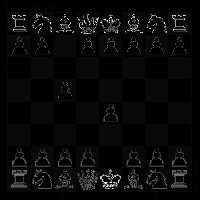

Prediction: [Lichess analysis](https://lichess.org/analysis/rnbqkbnr/pp1ppppp/11111111/11p11111/1111P111/11111111/PPPP1PPP/RNBQKBNR)

FEN: rnbqkbnr/pp1ppppp/11111111/11p11111/1111P111/11111111/PPPP1PPP/RNBQKBNR


In [21]:
makePrediction('http://www.caissa.com/chess-openings/img/siciliandefense1.gif')

Image on which to make prediction: http://www.jinchess.com/chessboard/?p=rnbqkbnrpPpppppp----------P----------------R----PP-PPPPPRNBQKBNR


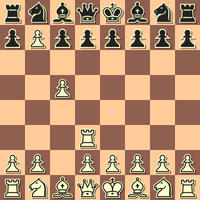

Prediction: [Lichess analysis](https://lichess.org/analysis/rnbqkbnr/pPpppppp/11111111/11P11111/11111111/111R1111/PP1PPPPP/RNBQKBNR)

FEN: rnbqkbnr/pPpppppp/11111111/11P11111/11111111/111R1111/PP1PPPPP/RNBQKBNR


In [22]:
makePrediction('http://www.jinchess.com/chessboard/?p=rnbqkbnrpPpppppp----------P----------------R----PP-PPPPPRNBQKBNR')

Ouch, tons of failures, interesting replacements, sometimes it's a missing piece, sometimes it's a white rook instead of a black king, or a bishop instead of a pawn, how interesting.